In [ ]:
# Labeling Single Cell Patient and Integrated Patients

In [1]:
from pathlib import Path
import re, warnings, os
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import torch
import seaborn as sns
import tqdm as notebook_tqdm
import matplotlib.pyplot as plt
import squidpy as sq
import celltypist
from celltypist import models
import adjustText

/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [2]:
# load pervious integrated sample
adata = sc.read_h5ad("integrated_P2_P5_scVI.h5ad")

# load single cell meta data
meta = (pd.read_csv("SingleCell_MetaData.csv")
          .assign(Barcode=lambda df: df["Barcode"].str.strip())
          .set_index("Barcode"))
adata.obs[["Level1", "Level2"]] = meta.loc[adata.obs_names, ["Level1", "Level2"]]


... storing 'Level1' as categorical
... storing 'Level2' as categorical


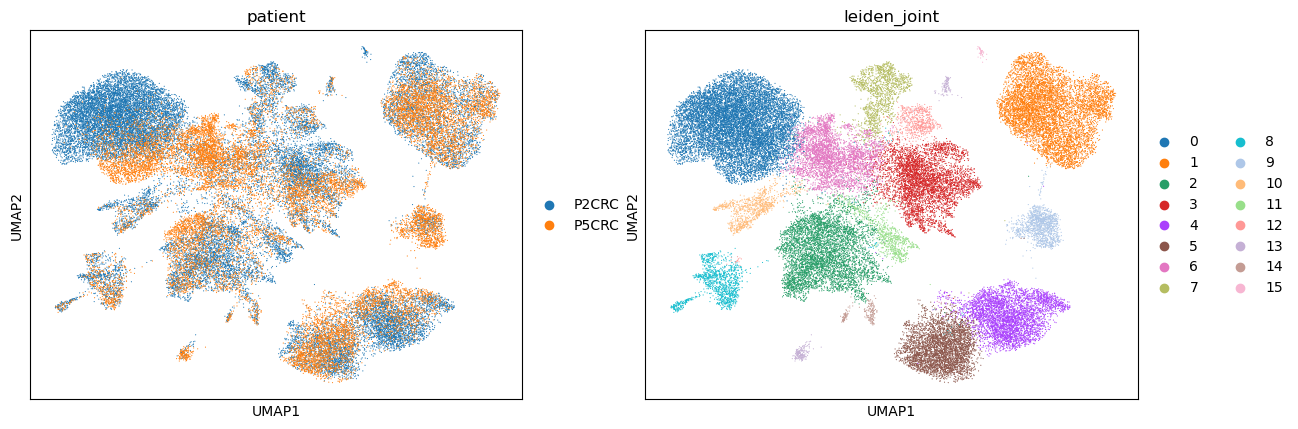

In [3]:
# already computed and plotted umap but do it anyway to check 

sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["patient", "leiden_joint"])


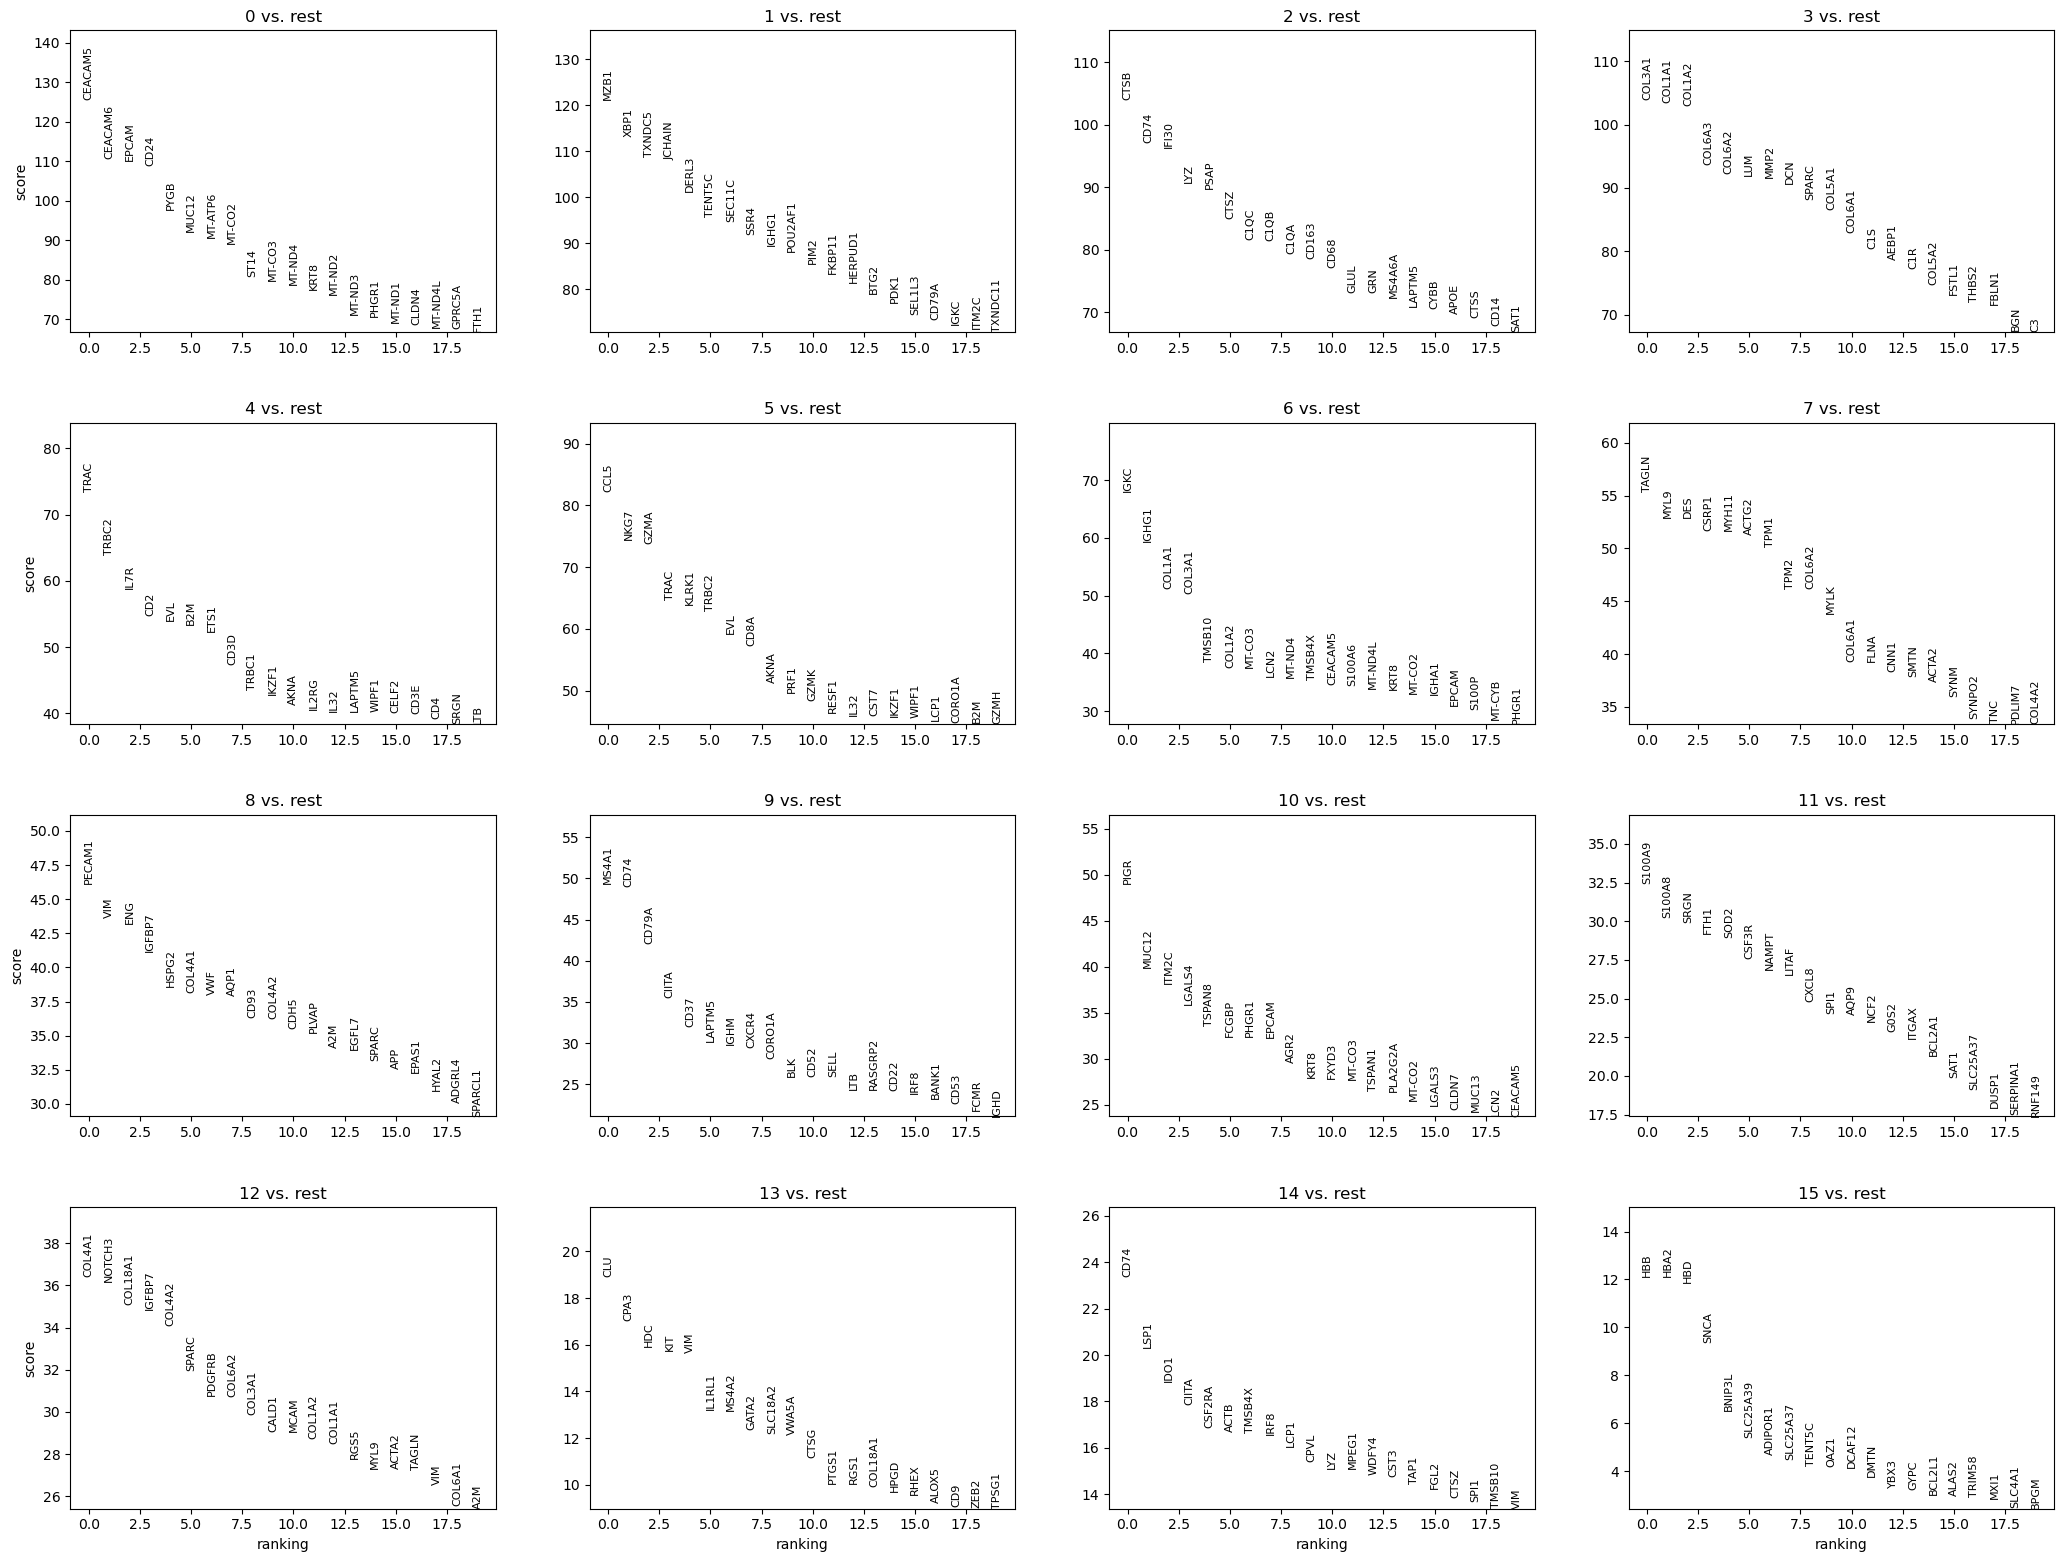

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,CEACAM5,125.546173,5.261457,0.0,0.0
1,0,CEACAM6,110.619614,5.017353,0.0,0.0
2,0,EPCAM,110.047409,4.762878,0.0,0.0
3,0,CD24,108.833199,4.560279,0.0,0.0
4,0,PYGB,97.538742,3.885247,0.0,0.0
5,0,MUC12,92.090317,4.461940,0.0,0.0
6,0,MT-ATP6,90.673538,2.566139,0.0,0.0
7,0,MT-CO2,89.054260,2.197802,0.0,0.0
8,0,ST14,80.744003,3.989844,0.0,0.0
9,0,MT-CO3,79.617065,1.865524,0.0,0.0


In [4]:
# Rank marker genes Top 20 used for later checking

sc.tl.rank_genes_groups(
    adata,
    groupby="leiden_joint",
    method="wilcoxon",
    key_added="rank_leiden"  
)
sc.pl.rank_genes_groups(adata, key="rank_leiden", n_genes=20, sharey=False)

df = sc.get.rank_genes_groups_df(adata, group=None, key="rank_leiden")
df.head(10)

In [5]:
from celltypist import models, annotate

ct_model = models.Model.load(model='Human_Colorectal_Cancer.pkl')

ct_res = annotate(
    adata,
    ct_model,
    majority_voting=True,   
)

# Add predicted labels to .obs  (change to seriies too)
adata.obs["celltype_ct"] = ct_res.predicted_labels["majority_voting"]

# look at cf score
prob_mat = ct_res.probability_matrix   
adata.obs["ct_conf"] = prob_mat.max(axis=1)

predictions = celltypist.annotate(adata, model = 'Human_Colorectal_Cancer.pkl', majority_voting = True)
predictions.predicted_labels

👀 Invalid expression matrix in `.X`, expect log1p normalized expression to 10000 counts per cell; will use `.raw.X` instead
🔬 Input data has 46447 cells and 16530 genes
🔗 Matching reference genes in the model
🧬 3724 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!
👀 Invalid expression matrix in `.X`, expect log1p normalized expression to 10000 counts per cell; will use `.raw.X` instead
🔬 Input data has 46447 cells and 16530 genes
🔗 Matching reference genes in the model
🧬 3724 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting th

,predicted_labels,over_clustering,majority_voting
AAACAAGCAACAGCTAACTTTAGG-1,IgG+ Plasma,0,IgG+ Plasma
AAACAAGCAACTGTTCACTTTAGG-1,Regulatory T cells,2,Regulatory T cells
AAACAAGCAAGGCCTGACTTTAGG-1,CMS2,8,CMS2
AAACAAGCAGGGCTATACTTTAGG-1,T helper 17 cells,12,T helper 17 cells
AAACAAGCATTGTGAGACTTTAGG-1,Unknown,13,Unknown
...,...,...,...
TTTGGACGTCCAGCACAGTAGGCT-23,Unknown,89,CD8+ T cells
TTTGGCGGTGAAGCACAGTAGGCT-23,CMS2,76,CMS2
TTTGGCGGTGCATTACAGTAGGCT-23,CD8+ T cells,267,cDC
TTTGGCGGTGCGTACCAGTAGGCT-23,Myofibroblasts,107,Stromal 3


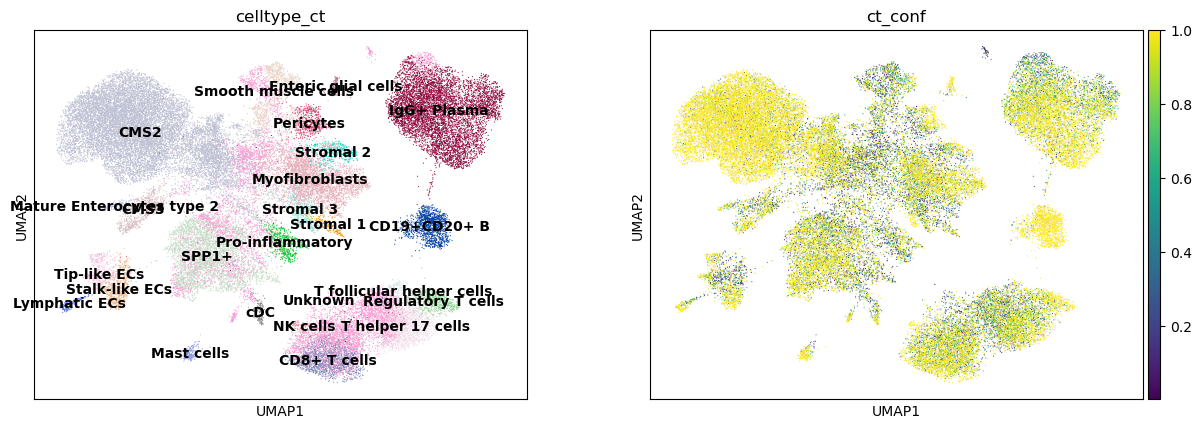

In [6]:
sc.pl.umap(adata, color=["celltype_ct", "ct_conf"], legend_loc="on data")


In [7]:
adata = predictions.to_adata()

In [8]:
adata.obs

,patient,suffix,sample_id,patient_tag,_scvi_batch,_scvi_labels,doublet,n_genes_by_counts,total_counts,total_counts_mt,...,leiden_local,leiden_joint,Level1,Level2,celltype_ct,ct_conf,predicted_labels,over_clustering,majority_voting,conf_score
AAACAAGCAACAGCTAACTTTAGG-1,P2CRC,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,0,0,False,715,1914.0,33.0,...,2,1,B cells,Plasma,IgG+ Plasma,0.902682,IgG+ Plasma,0,IgG+ Plasma,0.902682
AAACAAGCAACTGTTCACTTTAGG-1,P2CRC,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,0,0,False,318,369.0,4.0,...,4,4,T cells,CD4 T cell,Regulatory T cells,0.881707,Regulatory T cells,2,Regulatory T cells,0.881707
AAACAAGCAAGGCCTGACTTTAGG-1,P2CRC,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,0,0,False,472,556.0,35.0,...,5,0,Tumor,Tumor III,CMS2,0.997146,CMS2,8,CMS2,0.997146
AAACAAGCAGGGCTATACTTTAGG-1,P2CRC,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,0,0,False,935,1223.0,38.0,...,4,4,T cells,CD4 T cell,T helper 17 cells,0.999998,T helper 17 cells,12,T helper 17 cells,0.999998
AAACAAGCATTGTGAGACTTTAGG-1,P2CRC,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,0,0,False,267,296.0,4.0,...,10,2,QC_Filtered,QC_Filtered,Unknown,0.956777,Unknown,13,Unknown,0.956777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGACGTCCAGCACAGTAGGCT-23,P5CRC,23,40k_HumanColonCancer_Flex_Multiplex_P2L4_P5CRC...,P5CRC,1,0,False,649,811.0,9.0,...,4,5,T cells,CD8 T cell,CD8+ T cells,0.980416,Unknown,89,CD8+ T cells,0.980416
TTTGGCGGTGAAGCACAGTAGGCT-23,P5CRC,23,40k_HumanColonCancer_Flex_Multiplex_P2L4_P5CRC...,P5CRC,1,0,False,1702,2513.0,87.0,...,2,0,Tumor,Tumor IV,CMS2,0.999674,CMS2,76,CMS2,0.999674
TTTGGCGGTGCATTACAGTAGGCT-23,P5CRC,23,40k_HumanColonCancer_Flex_Multiplex_P2L4_P5CRC...,P5CRC,1,0,False,494,615.0,8.0,...,14,14,Myeloid,cDC I,cDC,0.685563,CD8+ T cells,267,cDC,0.685563
TTTGGCGGTGCGTACCAGTAGGCT-23,P5CRC,23,40k_HumanColonCancer_Flex_Multiplex_P2L4_P5CRC...,P5CRC,1,0,False,276,1007.0,4.0,...,5,3,Fibroblast,CAF,Stromal 3,0.142460,Myofibroblasts,107,Stromal 3,0.142460


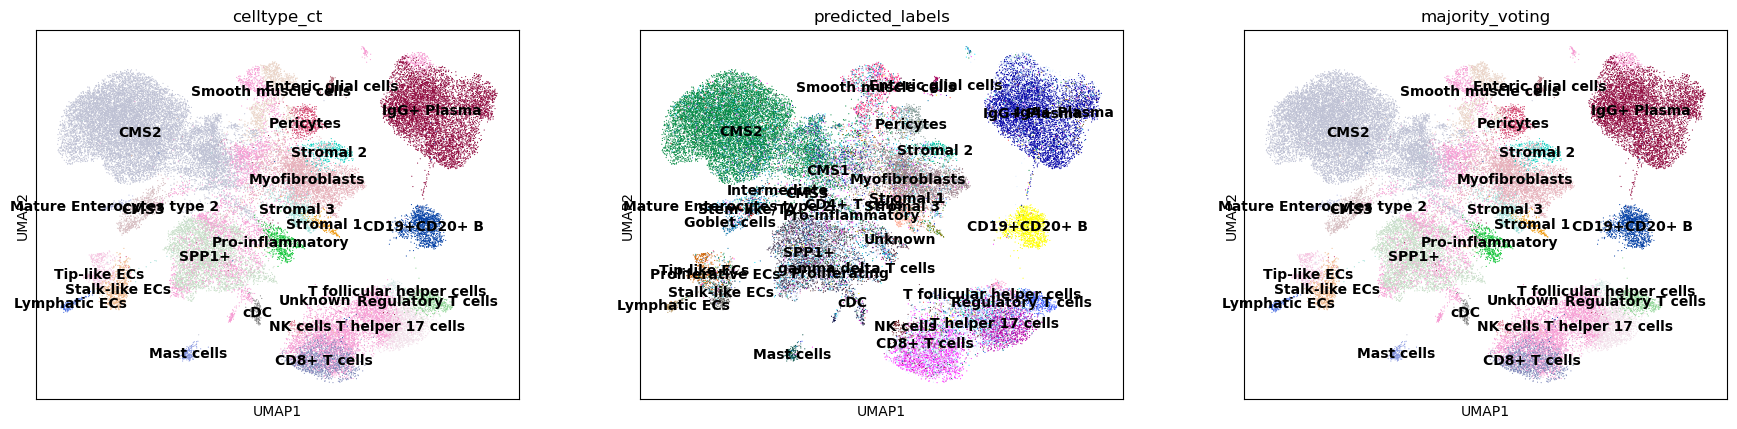

In [9]:
sc.tl.umap(adata)
sc.pl.umap(adata, color = ['celltype_ct', 'predicted_labels', 'majority_voting'], legend_loc = 'on data')

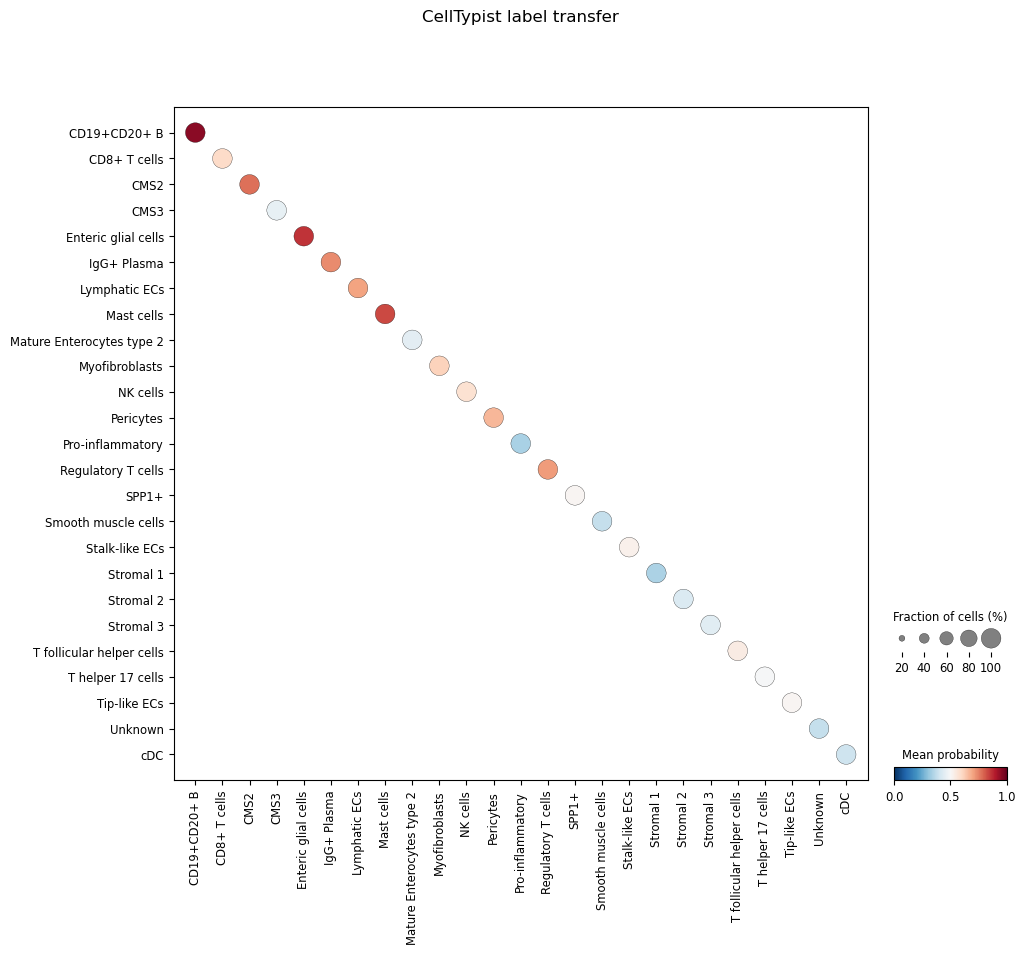

In [10]:
celltypist.dotplot(predictions, use_as_reference = 'celltype_ct', use_as_prediction = 'majority_voting')

In [11]:
#comparing rows from the cell typist to the singlecell_metadata
pd.crosstab(adata.obs["Level2"], adata.obs["celltype_ct"]).head(20)

celltype_ct,CD19+CD20+ B,CD8+ T cells,CMS2,CMS3,Enteric glial cells,IgG+ Plasma,Lymphatic ECs,Mast cells,Mature Enterocytes type 2,Myofibroblasts,...,Smooth muscle cells,Stalk-like ECs,Stromal 1,Stromal 2,Stromal 3,T follicular helper cells,T helper 17 cells,Tip-like ECs,Unknown,cDC
Level2,,,,,,,,,,,,,,,,,,,,,
Adipocyte,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,10,0,0,0,0,0
CAF,1,0,46,0,0,5,0,0,0,2884,...,6,2,18,293,236,0,0,0,194,0
CD4 T cell,0,1,4,0,0,6,0,0,0,0,...,1,4,0,0,0,170,1254,0,1504,1
CD8 T cell,5,1179,3,1,0,1,0,0,0,0,...,2,6,0,0,0,1,82,0,2117,0
Endothelial,0,0,5,0,0,0,0,0,0,0,...,0,517,0,0,1,0,0,404,8,0
Enteric Glial,0,0,3,0,97,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
Enterocyte,0,0,3,33,0,0,0,0,94,0,...,0,0,0,0,0,0,0,0,3,0
Epithelial,0,0,2,9,0,0,0,0,0,0,...,54,0,0,1,3,0,0,0,20,0
Fibroblast,0,0,2,0,0,0,0,0,0,31,...,0,0,125,4,230,0,0,0,9,0


In [12]:
# make scanvi cell predictions 

#  categorical dtype, you can convert to string early, since level 2 is catagorical we can't filll with unnkwin 
# convert to string 
# make a new category called seed_labels, here we use the single cell meta data labels for training and if not needed use the level 2 predictions
# Safe way: convert everything to string and fillna
adata.obs["seed_labels"] = (
    adata.obs["Level2"]
    .astype(str)
    .where(adata.obs["Level2"].notna(), adata.obs["celltype_ct"].astype(str))
    .fillna("Unknown")
)



INFO     Training for 200 epochs.                                                                                  


Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Epoch 200/200: 100%|█████████| 200/200 [12:04<00:00,  3.52s/it, v_num=1, train_loss_step=192, train_loss_epoch=209]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|█████████| 200/200 [12:04<00:00,  3.62s/it, v_num=1, train_loss_step=192, train_loss_epoch=209]


... storing 'celltype_scanvi' as categorical


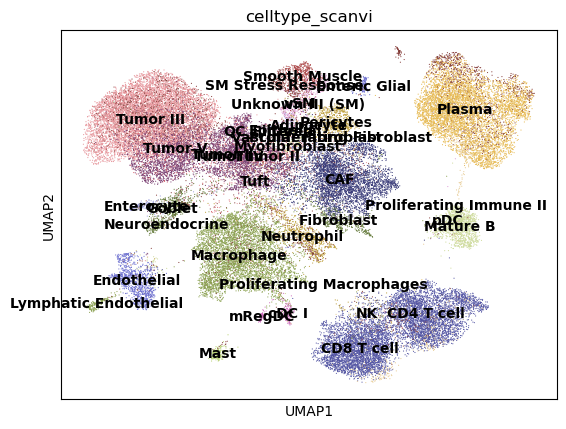

In [23]:
#scanvi model 

scvi.model.SCANVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="patient",
    labels_key="seed_labels",
    unlabeled_category="Unknown"
)

scanvi = scvi.model.SCANVI(adata, n_latent=30)
scanvi.train(max_epochs=200)         

adata.obs["celltype_scanvi"] = scanvi.predict(soft=False)
sc.pl.umap(adata, color="celltype_scanvi", legend_loc="on data")


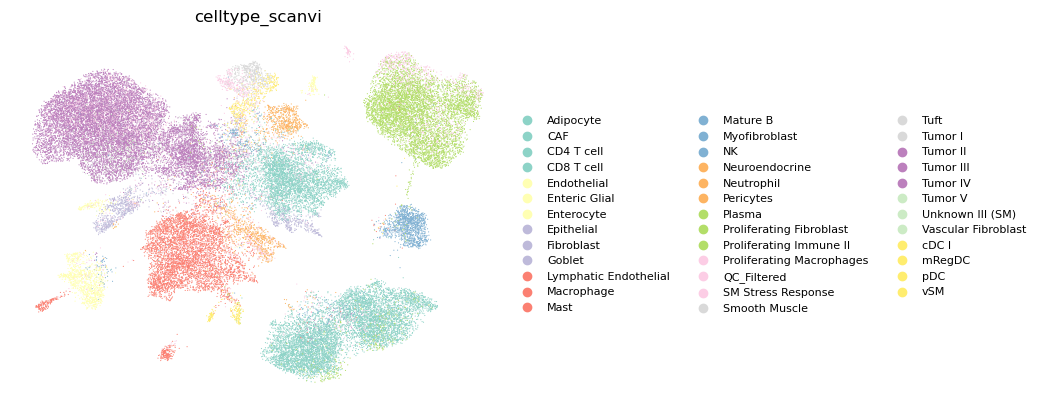

In [33]:
sc.pl.umap(
    adata,
    color="celltype_scanvi",
    legend_loc="right margin",  # clean layout
    legend_fontsize=8,
    frameon=False,
    title="celltype_scanvi",
    show=True
)


In [15]:
adata.obs

,patient,suffix,sample_id,patient_tag,_scvi_batch,_scvi_labels,doublet,n_genes_by_counts,total_counts,total_counts_mt,...,Level1,Level2,celltype_ct,ct_conf,predicted_labels,over_clustering,majority_voting,conf_score,seed_labels,celltype_scanvi
AAACAAGCAACAGCTAACTTTAGG-1,P2CRC,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,0,20,False,715,1914.0,33.0,...,B cells,Plasma,IgG+ Plasma,0.902682,IgG+ Plasma,0,IgG+ Plasma,0.902682,Plasma,Plasma
AAACAAGCAACTGTTCACTTTAGG-1,P2CRC,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,0,2,False,318,369.0,4.0,...,T cells,CD4 T cell,Regulatory T cells,0.881707,Regulatory T cells,2,Regulatory T cells,0.881707,CD4 T cell,CD4 T cell
AAACAAGCAAGGCCTGACTTTAGG-1,P2CRC,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,0,30,False,472,556.0,35.0,...,Tumor,Tumor III,CMS2,0.997146,CMS2,8,CMS2,0.997146,Tumor III,Tumor III
AAACAAGCAGGGCTATACTTTAGG-1,P2CRC,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,0,2,False,935,1223.0,38.0,...,T cells,CD4 T cell,T helper 17 cells,0.999998,T helper 17 cells,12,T helper 17 cells,0.999998,CD4 T cell,CD4 T cell
AAACAAGCATTGTGAGACTTTAGG-1,P2CRC,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,0,24,False,267,296.0,4.0,...,QC_Filtered,QC_Filtered,Unknown,0.956777,Unknown,13,Unknown,0.956777,QC_Filtered,QC_Filtered
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGACGTCCAGCACAGTAGGCT-23,P5CRC,23,40k_HumanColonCancer_Flex_Multiplex_P2L4_P5CRC...,P5CRC,1,3,False,649,811.0,9.0,...,T cells,CD8 T cell,CD8+ T cells,0.980416,Unknown,89,CD8+ T cells,0.980416,CD8 T cell,CD8 T cell
TTTGGCGGTGAAGCACAGTAGGCT-23,P5CRC,23,40k_HumanColonCancer_Flex_Multiplex_P2L4_P5CRC...,P5CRC,1,31,False,1702,2513.0,87.0,...,Tumor,Tumor IV,CMS2,0.999674,CMS2,76,CMS2,0.999674,Tumor IV,Tumor IV
TTTGGCGGTGCATTACAGTAGGCT-23,P5CRC,23,40k_HumanColonCancer_Flex_Multiplex_P2L4_P5CRC...,P5CRC,1,35,False,494,615.0,8.0,...,Myeloid,cDC I,cDC,0.685563,CD8+ T cells,267,cDC,0.685563,cDC I,cDC I
TTTGGCGGTGCGTACCAGTAGGCT-23,P5CRC,23,40k_HumanColonCancer_Flex_Multiplex_P2L4_P5CRC...,P5CRC,1,1,False,276,1007.0,4.0,...,Fibroblast,CAF,Stromal 3,0.142460,Myofibroblasts,107,Stromal 3,0.142460,CAF,CAF


In [17]:
adata.obs

,patient,suffix,sample_id,patient_tag,_scvi_batch,_scvi_labels,doublet,n_genes_by_counts,total_counts,total_counts_mt,...,Level1,Level2,celltype_ct,ct_conf,predicted_labels,over_clustering,majority_voting,conf_score,seed_labels,celltype_scanvi
AAACAAGCAACAGCTAACTTTAGG-1,P2CRC,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,0,20,False,715,1914.0,33.0,...,B cells,Plasma,IgG+ Plasma,0.902682,IgG+ Plasma,0,IgG+ Plasma,0.902682,Plasma,Plasma
AAACAAGCAACTGTTCACTTTAGG-1,P2CRC,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,0,2,False,318,369.0,4.0,...,T cells,CD4 T cell,Regulatory T cells,0.881707,Regulatory T cells,2,Regulatory T cells,0.881707,CD4 T cell,CD4 T cell
AAACAAGCAAGGCCTGACTTTAGG-1,P2CRC,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,0,30,False,472,556.0,35.0,...,Tumor,Tumor III,CMS2,0.997146,CMS2,8,CMS2,0.997146,Tumor III,Tumor III
AAACAAGCAGGGCTATACTTTAGG-1,P2CRC,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,0,2,False,935,1223.0,38.0,...,T cells,CD4 T cell,T helper 17 cells,0.999998,T helper 17 cells,12,T helper 17 cells,0.999998,CD4 T cell,CD4 T cell
AAACAAGCATTGTGAGACTTTAGG-1,P2CRC,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,0,24,False,267,296.0,4.0,...,QC_Filtered,QC_Filtered,Unknown,0.956777,Unknown,13,Unknown,0.956777,QC_Filtered,QC_Filtered
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGACGTCCAGCACAGTAGGCT-23,P5CRC,23,40k_HumanColonCancer_Flex_Multiplex_P2L4_P5CRC...,P5CRC,1,3,False,649,811.0,9.0,...,T cells,CD8 T cell,CD8+ T cells,0.980416,Unknown,89,CD8+ T cells,0.980416,CD8 T cell,CD8 T cell
TTTGGCGGTGAAGCACAGTAGGCT-23,P5CRC,23,40k_HumanColonCancer_Flex_Multiplex_P2L4_P5CRC...,P5CRC,1,31,False,1702,2513.0,87.0,...,Tumor,Tumor IV,CMS2,0.999674,CMS2,76,CMS2,0.999674,Tumor IV,Tumor IV
TTTGGCGGTGCATTACAGTAGGCT-23,P5CRC,23,40k_HumanColonCancer_Flex_Multiplex_P2L4_P5CRC...,P5CRC,1,35,False,494,615.0,8.0,...,Myeloid,cDC I,cDC,0.685563,CD8+ T cells,267,cDC,0.685563,cDC I,cDC I
TTTGGCGGTGCGTACCAGTAGGCT-23,P5CRC,23,40k_HumanColonCancer_Flex_Multiplex_P2L4_P5CRC...,P5CRC,1,1,False,276,1007.0,4.0,...,Fibroblast,CAF,Stromal 3,0.142460,Myofibroblasts,107,Stromal 3,0.142460,CAF,CAF


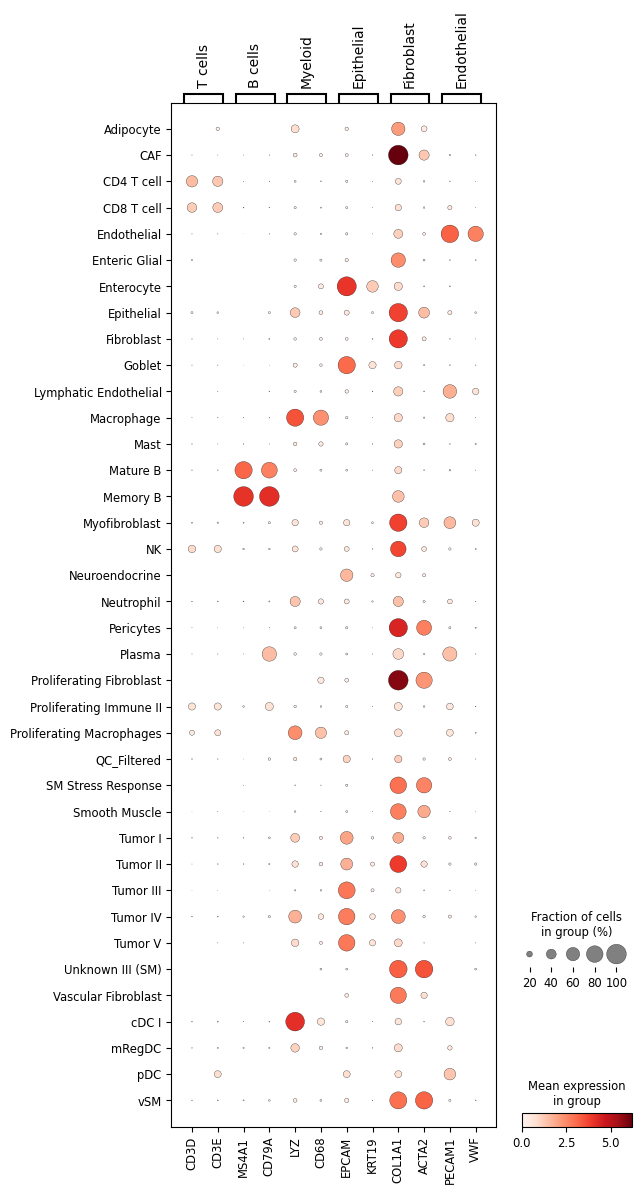

In [18]:
# confusion Level2 vs scANVI
pd.crosstab(adata.obs["Level2"], adata.obs["celltype_scanvi"]).head(25)

# confusion CellTypist vs scANVI
pd.crosstab(adata.obs["celltype_ct"], adata.obs["celltype_scanvi"]).head(25)

#  marker dot-plot
marker_dict = {
    "T cells"     : ["CD3D","CD3E"],
    "B cells"     : ["MS4A1","CD79A"],
    "Myeloid"     : ["LYZ","CD68"],
    "Epithelial"  : ["EPCAM","KRT19"],
    "Fibroblast"  : ["COL1A1","ACTA2"],
    "Endothelial" : ["PECAM1","VWF"],
}
sc.pl.dotplot(adata, marker_dict, groupby="celltype_scanvi")


In [19]:
adata.write("P2P5_labeled.h5ad", compression="gzip")

In [20]:
adata.obs

,patient,suffix,sample_id,patient_tag,_scvi_batch,_scvi_labels,doublet,n_genes_by_counts,total_counts,total_counts_mt,...,Level1,Level2,celltype_ct,ct_conf,predicted_labels,over_clustering,majority_voting,conf_score,seed_labels,celltype_scanvi
AAACAAGCAACAGCTAACTTTAGG-1,P2CRC,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,0,20,False,715,1914.0,33.0,...,B cells,Plasma,IgG+ Plasma,0.902682,IgG+ Plasma,0,IgG+ Plasma,0.902682,Plasma,Plasma
AAACAAGCAACTGTTCACTTTAGG-1,P2CRC,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,0,2,False,318,369.0,4.0,...,T cells,CD4 T cell,Regulatory T cells,0.881707,Regulatory T cells,2,Regulatory T cells,0.881707,CD4 T cell,CD4 T cell
AAACAAGCAAGGCCTGACTTTAGG-1,P2CRC,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,0,30,False,472,556.0,35.0,...,Tumor,Tumor III,CMS2,0.997146,CMS2,8,CMS2,0.997146,Tumor III,Tumor III
AAACAAGCAGGGCTATACTTTAGG-1,P2CRC,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,0,2,False,935,1223.0,38.0,...,T cells,CD4 T cell,T helper 17 cells,0.999998,T helper 17 cells,12,T helper 17 cells,0.999998,CD4 T cell,CD4 T cell
AAACAAGCATTGTGAGACTTTAGG-1,P2CRC,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,0,24,False,267,296.0,4.0,...,QC_Filtered,QC_Filtered,Unknown,0.956777,Unknown,13,Unknown,0.956777,QC_Filtered,QC_Filtered
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGACGTCCAGCACAGTAGGCT-23,P5CRC,23,40k_HumanColonCancer_Flex_Multiplex_P2L4_P5CRC...,P5CRC,1,3,False,649,811.0,9.0,...,T cells,CD8 T cell,CD8+ T cells,0.980416,Unknown,89,CD8+ T cells,0.980416,CD8 T cell,CD8 T cell
TTTGGCGGTGAAGCACAGTAGGCT-23,P5CRC,23,40k_HumanColonCancer_Flex_Multiplex_P2L4_P5CRC...,P5CRC,1,31,False,1702,2513.0,87.0,...,Tumor,Tumor IV,CMS2,0.999674,CMS2,76,CMS2,0.999674,Tumor IV,Tumor IV
TTTGGCGGTGCATTACAGTAGGCT-23,P5CRC,23,40k_HumanColonCancer_Flex_Multiplex_P2L4_P5CRC...,P5CRC,1,35,False,494,615.0,8.0,...,Myeloid,cDC I,cDC,0.685563,CD8+ T cells,267,cDC,0.685563,cDC I,cDC I
TTTGGCGGTGCGTACCAGTAGGCT-23,P5CRC,23,40k_HumanColonCancer_Flex_Multiplex_P2L4_P5CRC...,P5CRC,1,1,False,276,1007.0,4.0,...,Fibroblast,CAF,Stromal 3,0.142460,Myofibroblasts,107,Stromal 3,0.142460,CAF,CAF


... storing 'celltype_scanvi' as categorical


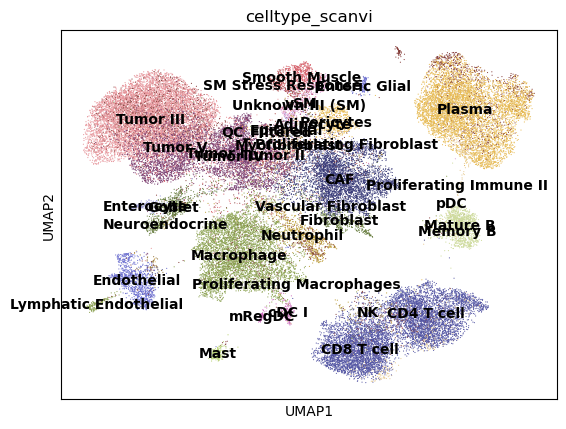

In [22]:
adata.obs["celltype_scanvi"] = scanvi.predict(soft=False)
sc.pl.umap(adata, color="celltype_scanvi", legend_loc="on data")

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


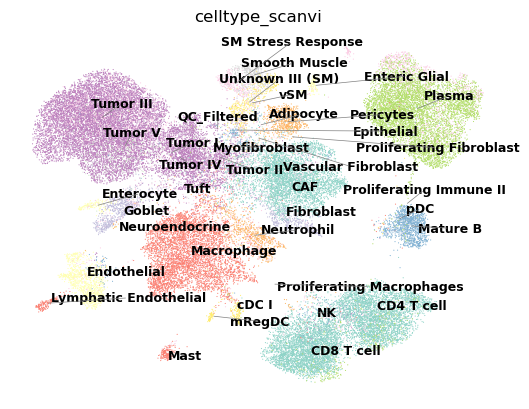

In [31]:


sc.pl.umap(
    adata,
    color="celltype_scanvi",
    frameon=False,
    show=False,
    title="celltype_scanvi",
    legend_loc=None
)

# 
coords = pd.DataFrame(adata.obsm["X_umap"], columns=["x", "y"])
coords["label"] = adata.obs["celltype_scanvi"].values
label_pos = coords.groupby("label")[["x", "y"]].median()

# Add labels with adjustText tutorial 
texts = []
for label, (x, y) in label_pos.iterrows():
    texts.append(plt.text(x, y, label, fontsize=9, weight='bold'))

adjust_text(
    texts,
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
    only_move={'points': 'y', 'text': 'xy'},  
    autoalign='y',
    expand_text=(1.05, 1.2)
)

plt.title("celltype_scanvi", fontsize=12)
plt.show()
